# Set of tools to visualize plots generated by Matlab

In [1]:
from pathlib import Path
import sys
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import gsw
import cartopy.crs as ccrs

path_MEOP_analyses = os.fspath(Path.home() / 'MEOP_analyses/')
if not (path_MEOP_analyses in sys.path):
        sys.path.insert(0,path_MEOP_analyses)

import importlib
import meop

In [2]:
list_data = meop.read_list_data_in_MEOP()
list_depl = meop.read_list_deployment()

In [7]:
list_depl.loc['ft05']

PI_CODE                        NPOLAR
PROCESS                             1
PUBLIC                              1
COUNTRY                        NORWAY
FIRST_VERSION     MEOP-CTD_2017-11-11
LAST_VERSION      MEOP-CTD_2020-01-02
START_DATE                 07/18/2010
END_DATE                   03/16/2011
START_DATE_JUL                   3852
Name: ft05, dtype: object

(<Figure size 720x720 with 1 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f5c2f09d9d0>)

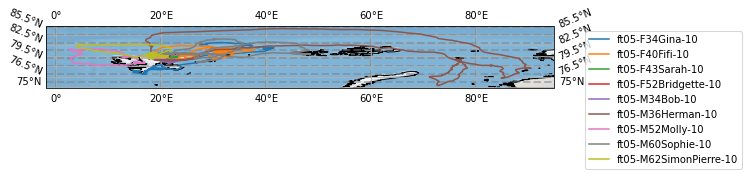

In [4]:
EXP = 'ft05'
meop.plot_map_deployments(list_data.loc[EXP])

In [6]:
# show descriptive plots for a given deployment
EXP = 'ct107'
meop.show_plots_depl(EXP,'_lr1')
#meop.show_plots_depl(EXP,'_hr1')
#meop.show_plots_depl(EXP,'_hr2')

In [10]:
# show descriptive plots for a given tag
one_smru_name = 'ct81-M250Ferdinan-11'
meop.show_plots_tag(one_smru_name)

In [8]:
importlib.reload(meop)
smru_name = 'ct107-933-13'
suffix='hr1'
ds = meop.read_ncfile(smru_name,qf=suffix)
ds = ds.assign_coords(pressure=("N_LEVELS", ds.PRES[0,:]))
ds['SIG0_ADJUSTED'] = (('N_PROF','N_LEVELS'),gsw.sigma0(ds.PSAL_ADJUSTED,ds.TEMP_ADJUSTED))

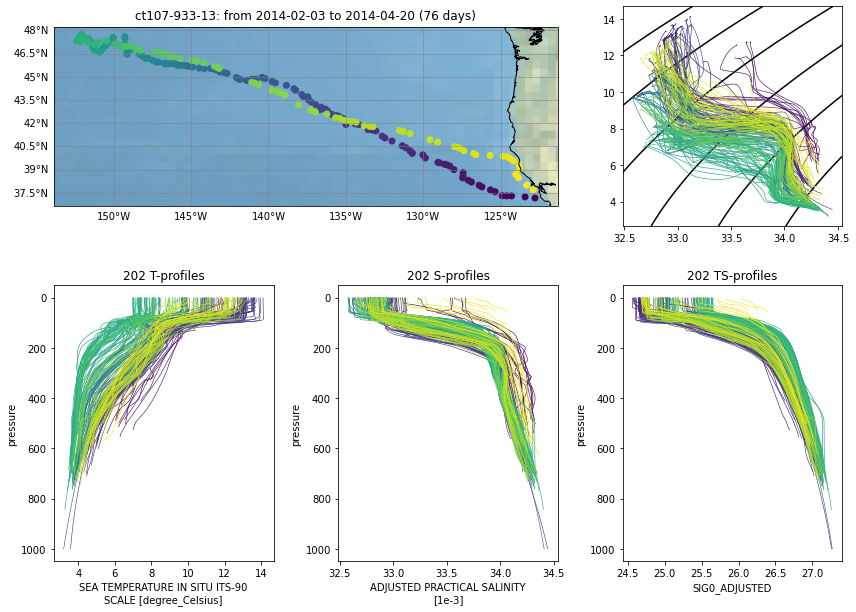

In [25]:
from cycler import cycler
cmap = plt.get_cmap('viridis',ds.dims['N_PROF'])
custom_cycler = cycler(color=cmap.colors)

fig = plt.figure(figsize=(12,9))
gs = fig.add_gridspec(2,3)

ax={}
ax['T'] = fig.add_subplot(gs[1, 0])
ax['S'] = fig.add_subplot(gs[1, 1])
ax['D'] = fig.add_subplot(gs[1, 2])
ax['TS'] = fig.add_subplot(gs[0, 2:])
ax['xy'] = fig.add_subplot(gs[0, :2],projection=ccrs.PlateCarree(central_longitude=0))
for key in ax:
    ax[key].set_prop_cycle(custom_cycler)

# T profiles
ds.TEMP_ADJUSTED.plot.line(ax = ax['T'], y='pressure',yincrease=False,hue='N_PROF',add_legend=False,linewidth=.6)
ax['T'].set_title(f"TEMP: {np.sum((ds.N_TEMP)>0).data} T-profiles")

# S profiles
ds.PSAL_ADJUSTED.plot.line(ax = ax['S'], y='pressure',yincrease=False,hue='N_PROF',add_legend=False,linewidth=.6)
ax['S'].set_title(f"PSAL: {np.sum((ds.N_PSAL)>0).data} S-profiles")

# sig0 profiles
ds.SIG0_ADJUSTED.plot.line(ax = ax['D'], y='pressure',yincrease=False,hue='N_PROF',add_legend=False,linewidth=.6)
ax['D'].set_title(f"SIG0: {np.sum((ds.N_PSAL*ds.N_TEMP)>0).data} TS-profiles")

# TS-diagram
for pp in ds.N_PROF:
    ax['TS'].plot(ds.PSAL_ADJUSTED.sel(N_PROF=pp),ds.TEMP_ADJUSTED.sel(N_PROF=pp),linewidth=.6)
x0,x1 = ax['TS'].get_xlim()
y0,y1 = ax['TS'].get_ylim()
X,Y = np.meshgrid(np.linspace(x0,x1),np.linspace(y0,y1))
D = gsw.sigma0(X,Y)
ax['TS'].set_aspect((x1-x0)/(y1-y0))
ax['TS'].contour(X,Y,D,colors='k')

# map
h=ds.plot.scatter(ax=ax['xy'],x='LONGITUDE',y='LATITUDE',hue='N_PROF',hue_style='continuous',
                  cmap=cmap,add_guide=False,transform=ccrs.PlateCarree())
gl = ax['xy'].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
          linewidth=1, color='gray', alpha=0.5)
gl.top_labels = False
gl.right_labels = False
ax['xy'].stock_img()
ax['xy'].coastlines()

# main title
start_date = ds.JULD.min()
end_date = ds.JULD.max()
num_days = (end_date-start_date).dt.days
ax['xy'].set_title(f"{smru_name}: from {start_date.dt.strftime('%Y-%m-%d').data} to {end_date.dt.strftime('%Y-%m-%d').data} ({num_days.data} days)")

# finitions
plt.tight_layout()

# save figure
depl = meop.EXP_from_SMRU_CODE(smru_name)
plotname = Path(processdir,'plots',depl,smru_name+'_'+suffix+'_python.png')
plt.savefig(plotname,dpi=300)

In [26]:
meop.show_png(plotname)

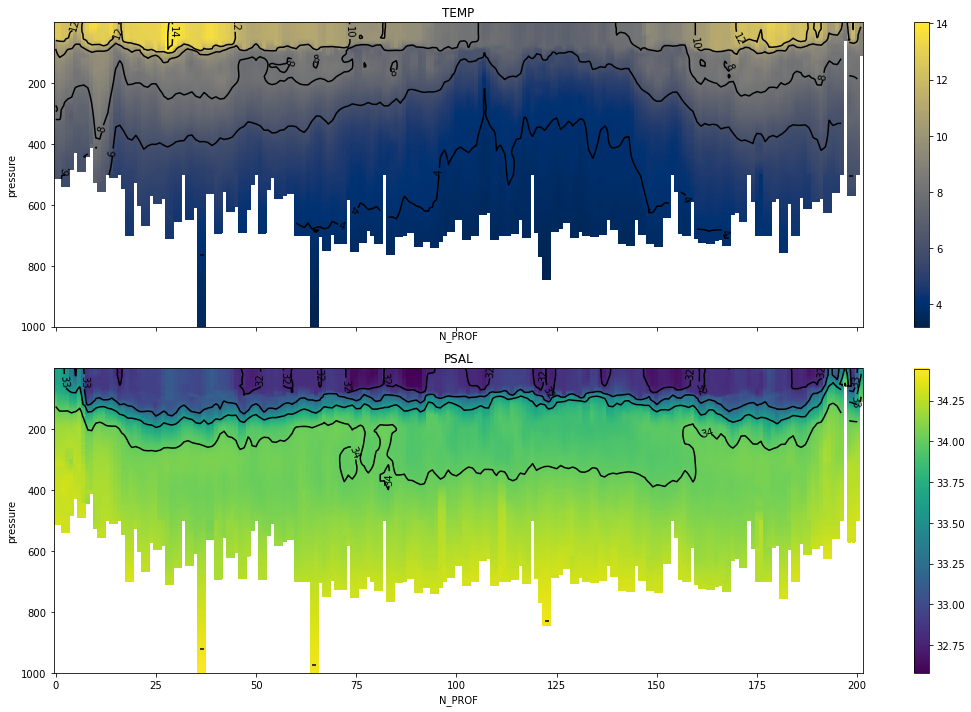

In [48]:
f, ax = plt.subplots(2,1, figsize=(15,10), sharex=True, sharey=True)

ds.TEMP_ADJUSTED.rolling(N_PROF=2, center=True, min_periods=1).mean().plot.pcolormesh(ax=ax[0],x='N_PROF',y='pressure',cmap=plt.get_cmap('cividis'),yincrease=False)
cs=ds.TEMP_ADJUSTED.rolling(N_PROF=2, center=True, min_periods=1).mean().plot.contour(ax=ax[0],x='N_PROF',y='pressure',levels=np.arange(-2,20,2),colors='k',yincrease=False)
ax[0].set_title('TEMP')
plt.clabel(cs,fmt='%d',inline_spacing=0)

ds.PSAL_ADJUSTED.rolling(N_PROF=2, center=True, min_periods=1).mean().plot.pcolormesh(ax=ax[1],x='N_PROF',y='pressure',yincrease=False)
cs=ds.PSAL_ADJUSTED.rolling(N_PROF=2, center=True, min_periods=1).mean().plot.contour(ax=ax[1],x='N_PROF',y='pressure',colors='k',yincrease=False)
ax[1].set_title('PSAL')
plt.clabel(cs,fmt='%d',inline_spacing=0)

plt.tight_layout()

In [52]:
importlib.reload(meop)
depl = 'ct107'
suffix='hr1'

list_tags = list_data.loc[depl].groupby('SMRU_PLATFORM_CODE').sum().index

In [54]:
list_ds = {}
for tag in list_tags:
    ds = meop.read_ncfile(tag,qf=suffix)
    ds = ds.assign_coords(pressure=("N_LEVELS", ds.PRES[0,:]))
    ds['SIG0_ADJUSTED'] = (('N_PROF','N_LEVELS'),gsw.sigma0(ds.PSAL_ADJUSTED,ds.TEMP_ADJUSTED))
    list_ds[tag] = ds

In [55]:
list_ds[next(iter(list_ds))]

<xarray.Dataset>
Dimensions:                       (N_CALIB: 1, N_LEVELS: 1000, N_PARAM: 4, N_PROF: 202)
Coordinates:
  * N_CALIB                       (N_CALIB) int64 0
  * N_LEVELS                      (N_LEVELS) int64 0 1 2 3 4 ... 996 997 998 999
  * N_PARAM                       (N_PARAM) int64 0 1 2 3
  * N_PROF                        (N_PROF) int64 0 1 2 3 4 ... 198 199 200 201
    pressure                      (N_LEVELS) float32 1.0 2.0 ... 999.0 1000.0
Data variables:
    DATA_TYPE                     object ...
    FORMAT_VERSION                object ...
    HANDBOOK_VERSION              object ...
    REFERENCE_DATE_TIME           object ...
    DATE_CREATION                 object ...
    DATE_UPDATE                   object ...
    PLATFORM_NUMBER               (N_PROF) object ...
    PROJECT_NAME                  (N_PROF) object ...
    PI_NAME                       (N_PROF) object ...
    STATION_PARAMETERS            (N_PROF, N_PARAM) object ...
    CYCLE_NUMBER                  (N_PROF) float64 ...
    DIRECTION                     (N_PROF) object ...
    DATA_CENTRE                   (N_PROF) object ...
    DC_REFERENCE                  (N_PROF) object ...
    DATA_STATE_INDICATOR          (N_PROF) object ...
    DATA_MODE                     (N_PROF) object ...
    INST_REFERENCE                (N_PROF) object ...
    WMO_INST_TYPE                 (N_PROF) object ...
    JULD                          (N_PROF) object ...
    JULD_QC                       (N_PROF) object ...
    JULD_LOCATION                 (N_PROF) object ...
    LATITUDE                      (N_PROF) float64 ...
    LONGITUDE                     (N_PROF) float64 ...
    POSITION_QC                   (N_PROF) object ...
    POSITIONING_SYSTEM            (N_PROF) object ...
    PROFILE_PRES_QC               (N_PROF) object ...
    PROFILE_PSAL_QC               (N_PROF) object ...
    PROFILE_TEMP_QC               (N_PROF) object ...
    PRES                          (N_PROF, N_LEVELS) float32 ...
    PRES_QC                       (N_PROF, N_LEVELS) object ...
    PRES_ADJUSTED                 (N_PROF, N_LEVELS) float32 ...
    PRES_ADJUSTED_QC              (N_PROF, N_LEVELS) object ...
    PRES_ADJUSTED_ERROR           (N_PROF, N_LEVELS) float32 ...
    TEMP                          (N_PROF, N_LEVELS) float32 ...
    TEMP_QC                       (N_PROF, N_LEVELS) object b'1' b'1' ... b'9'
    TEMP_ADJUSTED                 (N_PROF, N_LEVELS) float32 12.709656 ... nan
    TEMP_ADJUSTED_QC              (N_PROF, N_LEVELS) object ...
    TEMP_ADJUSTED_ERROR           (N_PROF, N_LEVELS) float32 ...
    PSAL                          (N_PROF, N_LEVELS) float32 ...
    PSAL_QC                       (N_PROF, N_LEVELS) object b'1' b'1' ... b'9'
    PSAL_ADJUSTED                 (N_PROF, N_LEVELS) float32 33.638695 ... nan
    PSAL_ADJUSTED_QC              (N_PROF, N_LEVELS) object ...
    PSAL_ADJUSTED_ERROR           (N_PROF, N_LEVELS) float32 ...
    PROFILE_CHLA_QC               (N_PROF) object ...
    CHLA                          (N_PROF, N_LEVELS) float32 ...
    CHLA_QC                       (N_PROF, N_LEVELS) object ...
    CHLA_ADJUSTED                 (N_PROF, N_LEVELS) float32 ...
    CHLA_ADJUSTED_QC              (N_PROF, N_LEVELS) object ...
    CHLA_ADJUSTED_ERROR           (N_PROF, N_LEVELS) float32 ...
    PARAMETER                     (N_PROF, N_CALIB, N_PARAM) object ...
    SCIENTIFIC_CALIB_EQUATION     (N_PROF, N_CALIB, N_PARAM) object ...
    SCIENTIFIC_CALIB_COEFFICIENT  (N_PROF, N_CALIB, N_PARAM) object ...
    N_TEMP                        (N_PROF) int64 514 502 540 484 ... 500 110 50
    N_PSAL                        (N_PROF) int64 514 502 540 484 ... 500 110 50
    SIG0_ADJUSTED                 (N_PROF, N_LEVELS) float64 25.28 25.28 ... nan
Attributes:
    comment:                   
    number_of_ts_profiles:    202.0
    number_of_t_profiles:     202.0
    number_chla_profiles:     0.0
    number_doxy_profiles:     0.0
   

NameError: name 'smru_name' is not defined

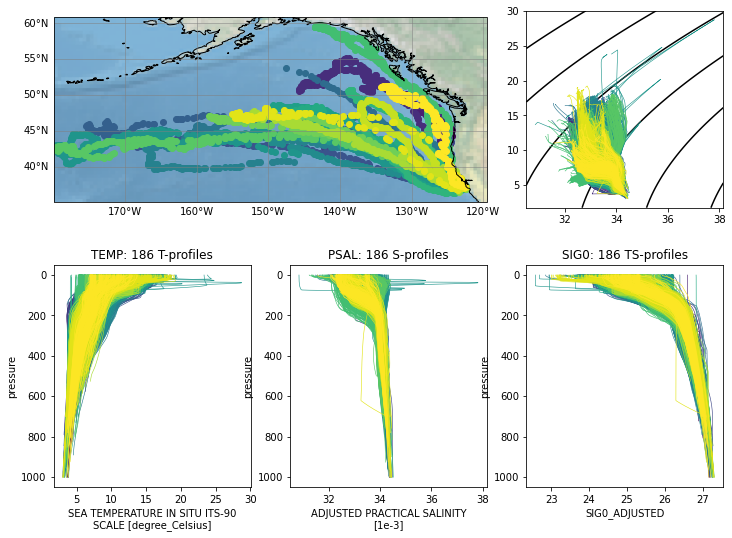

In [47]:
cmap = plt.get_cmap('viridis',len(list_ds))

fig = plt.figure(figsize=(12,9))
gs = fig.add_gridspec(2,3)

ax={}
ax['T'] = fig.add_subplot(gs[1, 0])
ax['S'] = fig.add_subplot(gs[1, 1])
ax['D'] = fig.add_subplot(gs[1, 2])
ax['TS'] = fig.add_subplot(gs[0, 2:])
ax['xy'] = fig.add_subplot(gs[0, :2],projection=ccrs.PlateCarree(central_longitude=0))
for key in ax:
    ax[key].set_prop_cycle(custom_cycler)

for kk,tag in enumerate(list_ds.keys()):
    
    ds = list_ds[tag]
    ds.TEMP_ADJUSTED.plot.line(ax = ax['T'], y='pressure',hue='N_PROF',color=cmap.colors[kk],yincrease=False,add_legend=False,linewidth=.6)
    ds.PSAL_ADJUSTED.plot.line(ax = ax['S'], y='pressure',hue='N_PROF',color=cmap.colors[kk],yincrease=False,add_legend=False,linewidth=.6)
    ds.SIG0_ADJUSTED.plot.line(ax = ax['D'], y='pressure',hue='N_PROF',color=cmap.colors[kk],yincrease=False,add_legend=False,linewidth=.6)
    for pp in ds.N_PROF:
        ax['TS'].plot(ds.PSAL_ADJUSTED.sel(N_PROF=pp),ds.TEMP_ADJUSTED.sel(N_PROF=pp),color=cmap.colors[kk],linewidth=.6)

    # map
    h=ds.plot.scatter(ax=ax['xy'],x='LONGITUDE',y='LATITUDE',
                      color=cmap.colors[kk],add_guide=False,transform=ccrs.PlateCarree())


ds = list_ds[next(iter(list_ds))]
ax['T'].set_title(f"TEMP: {np.sum((ds.N_TEMP)>0).data} T-profiles")
ax['S'].set_title(f"PSAL: {np.sum((ds.N_PSAL)>0).data} S-profiles")
ax['D'].set_title(f"SIG0: {np.sum((ds.N_PSAL*ds.N_TEMP)>0).data} TS-profiles")

x0,x1 = ax['TS'].get_xlim()
y0,y1 = ax['TS'].get_ylim()
ax['TS'].set_aspect((x1-x0)/(y1-y0))
X,Y = np.meshgrid(np.linspace(x0,x1),np.linspace(y0,y1))
D = gsw.sigma0(X,Y)
ax['TS'].contour(X,Y,D,colors='k')

gl = ax['xy'].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
      linewidth=1, color='gray', alpha=0.5)
gl.top_labels = False
gl.right_labels = False
ax['xy'].stock_img()
ax['xy'].coastlines()

# main title
start_date = ds.JULD.min()
end_date = ds.JULD.max()
num_days = (end_date-start_date).dt.days
ax['xy'].set_title(f"{smru_name}: from {start_date.dt.strftime('%Y-%m-%d').data} to {end_date.dt.strftime('%Y-%m-%d').data} ({num_days.data} days)")

# finitions
plt.tight_layout()

# save figure
depl = meop.EXP_from_SMRU_CODE(smru_name)
plotname = Path(processdir,'plots',depl,depl+'_'+suffix+'_python.png')
plt.savefig(plotname,dpi=300)

In [53]:
for tag in list_ds.keys():
    list_ds[tag].close()

In [1]:
ds_merge

NameError: name 'ds_merge' is not defined

In [54]:
ds = meop.read_ncfile(smru_name,qf=suffix)
ds = ds.assign_coords(pressure=("N_LEVELS", ds.PRES[0,:]))
ds['SIG0_ADJUSTED'] = (('N_PROF','N_LEVELS'),gsw.sigma0(ds.PSAL_ADJUSTED,ds.TEMP_ADJUSTED))
ds = ds.assign_coords({"N_TAG": ds.smru_platform_code}).expand_dims(N_TAG=1)

list_data

In [53]:
# navigate through descriptive plots for a given list of tags
EXP = 'ct107'
list_files = sorted(Path(processdir,'plots',EXP).glob('**/*_hr2_diags_TS_adj.png'))
meop.scroll_descriptive_plots_depl(list_files)

interactive(children=(BoundedIntText(value=0, description='Figure:', max=21), Dropdown(description='file:', op…

In [54]:
# navigate through calibration plots for a given list of tags
EXP = 'ct107'
list_files = sorted(Path(processdir,'calibration_plots',EXP).glob('**/calibration_*_0.png'))
meop.scroll_calibration_plots_depl(list_files)

interactive(children=(BoundedIntText(value=0, description='Figure:', max=21), Dropdown(description='file:', op…